# Protein Representation 101

**Objective**: compare one-hot encoding vs ESM-2 embeddings

## Step 1. The Biological Context
Unlike DNA, where A always pairs with T, Amino Acids have wildly different physical properties.

* Small vs. Large: Glycine (G) is tiny; Tryptophan (W) is massive.
* Hydrophobic vs. Hydrophilic: Some love water (Serine), some hide from it (Leucine).
* Charge: Some are positive (Lysine), some are negative (Aspartic Acid).

The Problem with One-Hot Encoding: In a one-hot vector, the distance between Glycine and Tryptophan is the same as Glycine and Alanine. The computer "thinks" they are all equally different. The Solution: Embeddings (like ESM-2) place chemically similar amino acids closer together in math space.

## Step 2. Setup and Installation

In [1]:
# Install the necessary library
# !pip install fair-esm

import torch
import esm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Step 3. One-hot encode a protein

In [2]:
def one_hot_protein(seq):
    # The 20 standard amino acids
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    aa_to_idx = {aa: i for i, aa in enumerate(amino_acids)}
    
    encoding = np.zeros((len(seq), len(amino_acids)))
    for i, aa in enumerate(seq):
        if aa in aa_to_idx:
            encoding[i, aa_to_idx[aa]] = 1
    return encoding

test_seq = "MAGA"
encoded = one_hot_protein(test_seq)
print(f"One-hot shape: {encoded.shape}") # (4, 20)

One-hot shape: (4, 20)


## Step 4. Extracting ESM-2 Embeddings
We will use the 8-million parameter model. It is tiny, fast, and runs perfectly on a CPU/laptop.

### Phase 1 Loading the brain
```
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
```
* `alphabet`: This is a specialized dictionary. **Converts protein (human readable) into integers (machine readable)**.
* `model`: This is the actual Neural Network (6 layers deep, 8 million parameters). It has already "read" millions of proteins and knows the rules of biology. **Convert integers (simple) into high-dimensional embeddings (complex)**
* `esm2_t6_8M_UR50D`: The name tells you it has 6 layers (t6) and 8 million parameters (8M). It’s the "lightweight" version.

In [3]:
# 1. Load the smallest ESM-2 model
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()

### Phase 2 Preparing the dictionary

* `batch_converter`: This is a helper tool. Its job is to take a list of sequences and "pad" them so they are all the same length, making them ready for the model.

* `model.eval()`: This stands for "evaluation mode." It tells the model: "Don't learn or change your weights right now, just give me the answers." It also turns off things like "Dropout" to ensure the output is consistent.

In [4]:
batch_converter = alphabet.get_batch_converter()
model.eval() 

ESM2(
  (embed_tokens): Embedding(33, 320, padding_idx=1)
  (layers): ModuleList(
    (0-5): 6 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=320, out_features=320, bias=True)
        (v_proj): Linear(in_features=320, out_features=320, bias=True)
        (q_proj): Linear(in_features=320, out_features=320, bias=True)
        (out_proj): Linear(in_features=320, out_features=320, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=320, out_features=1280, bias=True)
      (fc2): Linear(in_features=1280, out_features=320, bias=True)
      (final_layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=120, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((320,), eps=1e-05, elementwis

### Phase 3 Text to Numbers

* `data`: ESM-2 expects a list of tuples. Each tuple is (name, sequence).
* `batch_tokens`: This is the most important output here. It converts "MAGA" into a row of numbers (integers). For example, M might become 12, A might become 5, etc. It also adds a "Start" and "End" number to the sequence.

In [5]:
# 2. Prepare data (ID, Sequence)
data = [("test_prot", "MAGA")]
batch_labels, batch_strs, batch_tokens = batch_converter(data)
(batch_labels, batch_strs, batch_tokens)

(['test_prot'], ['MAGA'], tensor([[ 0, 20,  5,  6,  5,  2]]))

### Phase 4 The inference (extraction)
* `with torch.no_grad()`: This tells the computer: "Don't save any math for backpropagation." This saves a massive amount of memory and prevents your laptop from slowing down.

* `results = model(...)`: We pass the numbers (batch_tokens) into the model.

* `repr_layers=[6]`: We specifically ask the model to give us the "thoughts" it has at its 6th layer (the final layer). The final layer usually contains the most complex biological information.

In [6]:
# 3. Extract the "Representations"
# This model has 6 layers. We usually take the output of the last layer.
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[6])


### Phase 5: The Final Mathematical Vector
* `embeddings`: We pull the numerical vectors out of the results dictionary.

The Shape `(1, 6, 320)`:

* 1: We processed 1 protein.
* 6: The length of the sequence + 2. (Our MAGA is 4 letters, plus a <cls> start token and a <eos> end token = 6).
* 320: This is the Embedding Dimension. Instead of a single letter M, the model describes M using 320 different numbers.

In [7]:
embeddings = results["representations"][6] # 6 -> layer6
embeddings.shape # (1, 6, 320)
# Note: shape is [Batch, Length + 2, Dimension]. 
# The +2 is for 'Start' and 'End' tokens.

torch.Size([1, 6, 320])

## Step 5. Visualization: chemical similarity

To evluate which method (one-hot encoding or embedding) is better, we will check the the model knows that Isoleucine(I) and Leucine(L) are similar.

### 5.1 Fetching the results

**Why `results["representations"][6][:, 1, :].numpy()`**

When you send a single amino acid (like "A") into ESM-2, the Alphabet automatically adds "Special Tokens" to it. Your 1-letter sequence actually becomes a 3-item list.

* Index 0: `cls` start of sequence
* Index 1: the amino acid
* Index 2: `eos` end of sequence

Because our task is to understand difference between each AA, we only need index 1.

**Importance of `cls` and `eos` tockens**

The [CLS] (short for Classification) token is the most powerful token in the model.

* How it works: Because of a mechanism called Self-Attention, every position in the sequence "talks" to every other position. The <cls> token is placed at the start so it can "listen" to the entire protein.   
( The Result: By the time the data reaches Layer 6, the 320 numbers at the <cls> position are no longer just a "start signal." They have become a mathematical summary of the whole protein.

The [EOS] (short for End of Sequence) token is like a biological period at the end of a sentence.

* The Logic: Transformers are designed to handle proteins of any length (up to 1024). Without an <eos> token, the model wouldn't know if a short 10bp sequence is a complete functional peptide or just the first half of a broken file.
* The Spatial Signal: It helps the model understand the relative distance of amino acids from the end of the chain, which is often where "C-terminal" signaling motifs live.


In [8]:
# Let's compare the embeddings of all 20 Amino Acids
standard_aas = "ACDEFGHIKLMNPQRSTVWY"
one_hot_encoding = one_hot_protein(standard_aas)
data = [(aa, aa) for aa in standard_aas]
_, _, tokens = batch_converter(data)


with torch.no_grad():
    results = model(tokens, repr_layers=[6])
    # We take the 1st index of each sequence (the actual AA)
    # skip the 0th index (start token) and the last index (end token)
    aa_embeddings = results["representations"][6][:, 1, :].numpy()

### 5.2 Analyzing the two methods:

|Metric|One-hot|ESM-2 Embedding|
|------|-------|---------------|
|Identical AA|1.0|1.0|
|Similar AA|0.0|0.98|
|Opposite AA|0.0|0.2|
|Relationship|Binary|Chemical similarity|

**Why the similarity scores are above 0.8 in ESM-2 embedding?**

1. Biology baseline

* Because ESM-2 is trained on all proteins, it recognizes that any protein is much more similar to another protein than it is to, say, a random sequence of English words or white noise.
* This shared "protein-ness" creates a high baseline similarity (often starting at 0.8).

2. Ansiotropy
* Research has shown that LLM embeddings often occupy a very narrow "cone" in the vector space.
* Even two completely "unrelated" proteins will have a high cosine similarity because they are both trapped inside this same narrow cone.



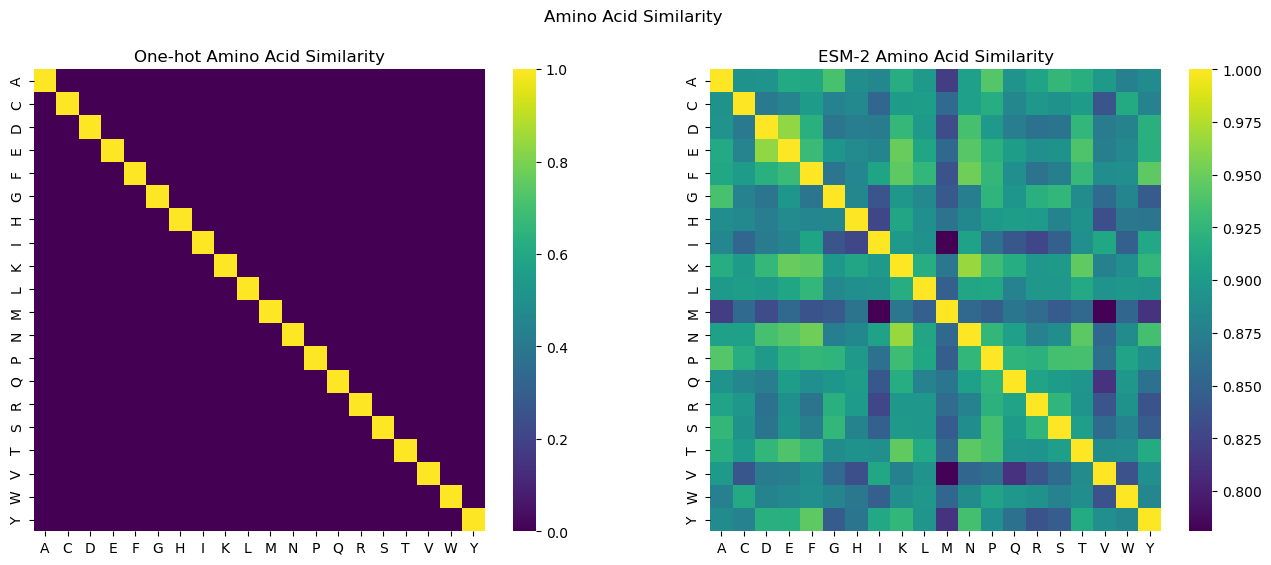

In [9]:
# Calculate Cosine Similarity between the amino acids
from sklearn.metrics.pairwise import cosine_similarity
sim_matrix = cosine_similarity(aa_embeddings)
sim_matrix_one_hot = cosine_similarity(one_hot_encoding)
# Plot Heatmap
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(sim_matrix_one_hot, xticklabels=standard_aas, yticklabels=standard_aas, cmap='viridis', ax=ax[0])
ax[0].set_title("One-hot Amino Acid Similarity")
sns.heatmap(
    sim_matrix, xticklabels=standard_aas, yticklabels=standard_aas, cmap='viridis',
    ax=ax[1],
    )
ax[1].set_title("ESM-2 Amino Acid Similarity")
plt.suptitle("Amino Acid Similarity")

plt.show()

In [10]:

one_hot_encoding.shape

(20, 20)